In [1]:
# Adaptation of https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
import dds
import sklearn
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import requests
import io
import json


In [2]:
%%sh
rm -rf /tmp/data/*
rm -rf /tmp/blobs/*
rm -rf /tmp/*.png

In [3]:
path_raw = "/wine-quality/raw"
path_model = "/wine-quality/my_model"
path_model_stats = "/wine-quality/my_model_stats.json"

def _load_data():
    print("*** in _load_data ***")
    url = "https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv"
    x = requests.get(url=url, verify=False).content 
    return pd.read_csv(io.StringIO(x.decode('utf8')), sep=";")


def data():
    return dds.keep(path_raw, _load_data)
# data = lambda: dds.keep(path_raw, _load_data)

In [4]:
data().head(3)

INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__._load_data> /wine-quality/raw <- ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function _load_data at 0x7fcac4eef280> with args [] kwargs OrderedDict()


*** in _load_data ***


/home/tjhunter/work/software/miniconda/envs/dds/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function _load_data at 0x7fcac4eef280>: completed
INFO:dds._api:_eval:Storing blob into key ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5
INFO:dds.codec:Loading pandas codecs
INFO:dds.store:Link /tmp/data/wine-quality/raw -> /tmp/blobs/ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [5]:
def build_model(X_train, y_train):
    print("*** in build_model ***")
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=100))
    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                      'randomforestregressor__max_depth': [None, 5, 3, 1]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    
    clf.fit(X_train, y_train)
    return clf
 
    
def model_stats(clf, X_test, y_test) -> str:
    print("*** in model_stats ***")
    pred = clf.predict(X_test)
    return json.dumps({
#         "r2_score": r2_score(y_test, pred),
        "mse": mean_squared_error(y_test, pred)
    })
    
    
def pipeline():
    wine_data = data()
    y = wine_data.quality
    X = wine_data.drop('quality', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.15, 
                                                        random_state=123, 
                                                        stratify=y)
    clf = dds.keep(path_model, build_model, X_train, y_train)
    dds.keep(path_model_stats, model_stats, clf, X_test, y_test)
    print("*** done ***")


dds.eval(pipeline, dds_export_graph="1.png")


INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.pipeline> @ 229b55671940c51e042f2ac064aa2d3bfc8f2058927b8aa619ba1b9bb5077091
INFO:dds._api:   |- Dep path_model -> <__main__.path_model>: 4697524b4c751aacee319944ec2f0a265336dc96ff692488d7cbc071fc6a3733
INFO:dds._api:   |- Dep path_model_stats -> <__main__.path_model_stats>: 110ff33eb1f89810ce6af6621ae232ae55f5408eb739bd82972c361bffaa48da
INFO:dds._api:   |- Fun <__main__.data> @ 5e8a4da56caebb0454d220e6ba491b35d7200a317b410d6a549d9d49e911b6b8
INFO:dds._api:   |  |- Ctx 2af8fc03bd539aff5bbf9ccae9d82d7921223c8b858fe0c0f2d53f8260794f49
INFO:dds._api:   |  |- Dep path_raw -> <__main__.path_raw>: a1a3ce5966bea811120114207d004b9d61fea3f19ca024e5d8d0632fb90c40f4
INFO:dds._api:   |  `- Fun <__main__._load_data> /wine-quality/raw <- ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5
INFO:dds._api:   |     `- Ctx ba4c7d935aed88c22a170e6814c291cc3106a429cd443d7cf78c35a749ee1120
INFO:dds._api:   |- Fun <__main__.build_mo

*** in build_model ***


INFO:dds._api:_eval:Evaluating (keep:/wine-quality/my_model) fun <function build_model at 0x7fcaba7da3a0>: completed
INFO:dds._api:_eval:Storing blob into key 6ef0a57e73e137b36f41b062f3a017321a83e3dbf25b89558b754772985a0dd3
INFO:dds._api:_eval:Evaluating (keep:/wine-quality/my_model_stats.json) fun <function model_stats at 0x7fcaba7da4c0> with args ["<class 'sklearn.model_selection._search.GridSearchCV'>", "<class 'pandas.core.frame.DataFrame'>", "<class 'pandas.core.series.Series'>"] kwargs OrderedDict()
INFO:dds._api:_eval:Evaluating (keep:/wine-quality/my_model_stats.json) fun <function model_stats at 0x7fcaba7da4c0>: completed
INFO:dds._api:_eval:Storing blob into key 05cac26ad02960d1e81685e3a8069b939544b0d8fdc801d3079e023c467eec15
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function pipeline at 0x7fcaba7da550>: completed
INFO:dds.store:Link /tmp/data/wine-quality/my_model -> /tmp/blobs/6ef0a57e73e137b36f41b062f3a017321a83e3dbf25b89558b754772985a0dd3
INFO:dds.store:Link /tmp

*** in model_stats ***
*** done ***


In [6]:
%%sh
cat /tmp/data/wine-quality/my_model_stats.json

{"mse": 0.32426791666666666}

In [7]:

@dds.dds_function("/p1")
def f1(): return 1

@dds.dds_function("/p2")
def f2(): return 1 + f1()

@dds.dds_function("/p3")
def f3(): return 1 + f1() + f2()

@dds.dds_function("/p4")
def f4(): return 1


def f():
    f3()
    f4()

dds.eval(f, dds_export_graph="/tmp/2.png")

INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.f> @ 89ff8094a3d0a94ef59ce8216f6af4ceb5e8368b2bcef0367a8c5870c70e0fec
INFO:dds._api:   |- Fun <__main__.f3> /p3 <- 8fc6e266b78cb972592445cf3327b646ce59d2e264a4dceaded723e5bdb88698
INFO:dds._api:   |  |- Ctx 6965b23fcfb9f5417d27a50bdf8e38d75626897c8ba4fec196e75e07e3b49183
INFO:dds._api:   |  |- Fun <__main__.f1> /p1 <- 21359b297a537138b18ae4b57935010efee0c458a9a198b974a89ac64ef5fdca
INFO:dds._api:   |  |  `- Ctx 209b35c622a4c2408e105534a13f1fa36e89aa2329c9fbf3325f4dff4d3271ab
INFO:dds._api:   |  `- Fun <__main__.f2> /p2 <- 9d71e25a2d042a3b14d1075a0ac40d7d573ae21b1226b8fd76b6584cc704d8e2
INFO:dds._api:   |     |- Ctx 4cd54885eb8292cd6bda87c464faa1db770a7dcf78ac83d008d5a08963711c13
INFO:dds._api:   |     `- Fun <__main__.f1> /p1 <- 21359b297a537138b18ae4b57935010efee0c458a9a198b974a89ac64ef5fdca
INFO:dds._api:   |        `- Ctx 055093f7e4f784a167ece2ca6104ed2a622e4f7367c985a5508563a01273e481
INFO:dds._api:   `- Fun <__main__.f

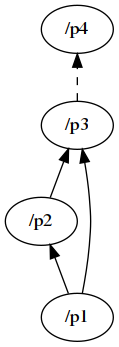

In [8]:
from IPython.display import Image
Image("/tmp/2.png")